In [1]:
import torch
from torch import nn
import torchvision

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms import v2

from matplotlib.ticker import AutoMinorLocator, MultipleLocator


import os
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from PIL import Image



In [2]:
class MyClass(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.Layer_1 = nn.Linear(input, 128)
        self.act = nn.ReLU()
        self.Layer_2 = nn.Linear(128, output)
        
    def forward(self, x):
        x = self.Layer_1(x)
        x = self.act(x)
        out = self.Layer_2(x)
        return out

model = MyClass(784, 10)
opt = torch.optim.Adam(model.parameters(), lr= 0.1)
loss_model = nn.CrossEntropyLoss()

### LambdaLR

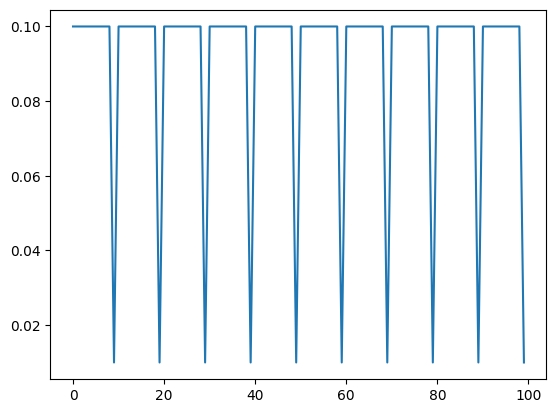

In [3]:
lr_lambda = lambda step: 0.1 if step % 10 == 0 else 1
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda = lr_lambda)

list_= []

for epoch in range(100):
    #Train
    for _ in range(1):
        opt.step()
    
    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()
    list_.append(lr)

plt.plot(list_)
plt.show()


### MultiStepLR

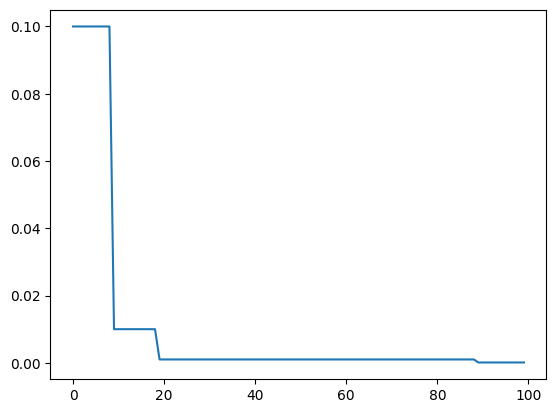

In [4]:
model = MyClass(784, 10)
opt = torch.optim.Adam(model.parameters(), lr= 0.1)
loss_model = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[10, 20, 90], gamma=0.1)

list_= []

for epoch in range(100):
    #Train
    for _ in range(1):
        opt.step()
    
    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()
    list_.append(lr)

plt.plot(list_)
plt.show()

### StepLR

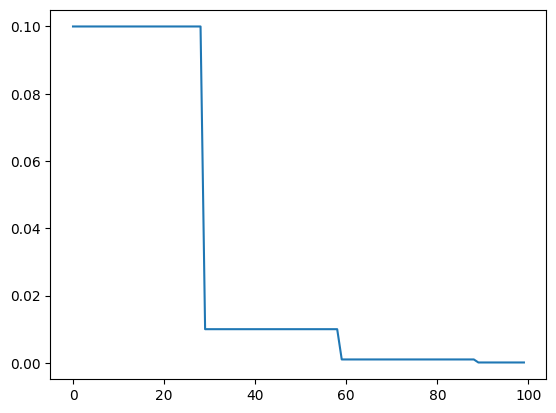

In [5]:
model = MyClass(784, 10)
opt = torch.optim.Adam(model.parameters(), lr= 0.1)
loss_model = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)

list_= []

for epoch in range(100):
    #Train
    for _ in range(1):
        opt.step()
    
    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()
    list_.append(lr)

plt.plot(list_)
plt.show()

### ExponentialLR

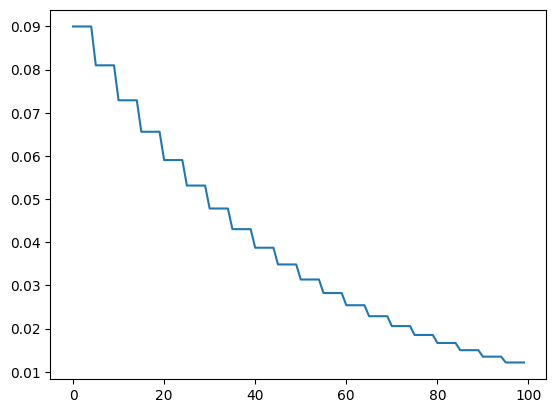

In [6]:
model = MyClass(784, 10)
opt = torch.optim.Adam(model.parameters(), lr= 0.1)
loss_model = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

list_= []

for epoch in range(100):
    #Train
    for _ in range(1):
        opt.step()

    if epoch % 5 == 0:
        lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()
    list_.append(lr)

plt.plot(list_)
plt.show()

### ReduseLROnpPlateua

In [7]:
model = MyClass(784, 10)
opt = torch.optim.Adam(model.parameters(), lr= 0.1)
loss_model = nn.CrossEntropyLoss()


lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                          mode = 'min', # 'min or max' за чем следим за уменьшением или увеличением
                                                          factor=0.1, # кооф на кот будет * скорость обучения
                                                          patience=10, # в течении каких эпох если нету измен будет изм lr
                                                          threshold=0.0001,
                                                          threshold_mode='rel', # 'rel' or 'abs'
                                                          cooldown=0,
                                                          min_lr=0,
                                                          eps=1e-8)

In [8]:
loss = torch.full([5,10], 0.1)
loss = loss * torch.tensor([1/i for i in range(1, 6)]).reshape([5, 1])
loss = loss.reshape([50])

In [9]:
model = MyClass(784, 10)

list_= []

for epoch in range(50):
    #Train
    for _ in range(1):
        opt.step()

    idx = epoch
    lr_scheduler.step(loss[idx])
    
    lr = lr_scheduler._last_lr[0]
    list_.append(lr)

# plt.plot(list_)
# plt.show()

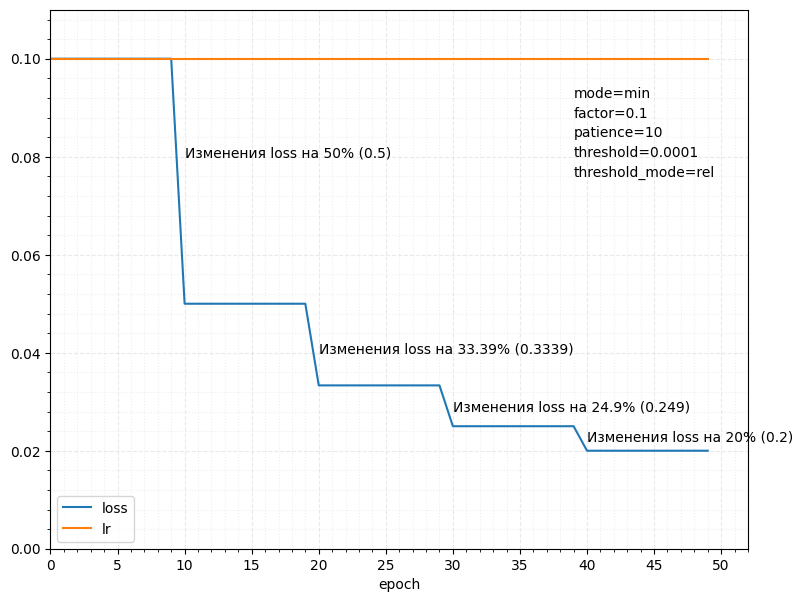

In [10]:
fix, ax = plt.subplots(figsize=[9, 7])

ax.plot(loss)
ax.plot(list_)

ax.set_xlim(0, 52)
ax.set_ylim(0, 0.11)

ax.xaxis.set_major_locator(MultipleLocator(5))

ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

ax.grid(which = 'major', color='#CCCCCC', linestyle='--', alpha=0.4)
ax.grid(which = 'minor', color='#CCCCCC', linestyle=':', alpha=0.3)

ax.legend(["loss", "lr"])
ax.set_xlabel("epoch")

if lr_scheduler.threshold_mode == "abs":
    ax.text(10, 0.08, 'Изменения loss на 0.05')
    ax.text(20, 0.04, 'Изменения loss на 0.0167')
    ax.text(30, 0.028, 'Изменения loss на 0.008')
    ax.text(40, 0.022, 'Изменения loss на 0.005')
else:
    ax.text(10, 0.08, 'Изменения loss на 50% (0.5)')
    ax.text(20, 0.04, 'Изменения loss на 33.39% (0.3339)')
    ax.text(30, 0.028, 'Изменения loss на 24.9% (0.249)')
    ax.text(40, 0.022, 'Изменения loss на 20% (0.2)')

ax.text(39, 0.092, f"mode={lr_scheduler.mode}")
ax.text(39, 0.088, f"factor={lr_scheduler.factor}")
ax.text(39, 0.084, f"patience={lr_scheduler.patience}")
ax.text(39, 0.080, f"threshold={lr_scheduler.threshold}")
ax.text(39, 0.076, f"threshold_mode={lr_scheduler.threshold_mode}")

plt.show()
    

# Задача регрессии

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
class DatasetReg(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.list_name_file = os.listdir(path)
        if "cords.json" in self.list_name_file:
            self.list_name_file.remove("cords.json")
        self.len_dataset = len(self.list_name_file)
        with open(os.path.join(self.path, "cords.json"), "r") as f:
            self.dict_cords = json.load(f)
            
    def __len__(self):
        return self.len_dataset
        
    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)
        
        img = Image.open(path_img)
        cords = torch.tensor(self.dict_cords[name_file], dtype= torch.float32)

        if self.transform is not None:
            img = self.transform(img)
        return img, cords
        

In [13]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std=(0.5,),)
    ]
)

In [14]:
dataset = DatasetReg(path = r"C:\Users\voron\IT\pytorch\dataset", transform=transform)

In [15]:
train_data, valid_data, test_data = random_split(dataset, [0.7, 0.1, 0.2])

In [16]:
bach_size = 32
train_loader = DataLoader(train_data, bach_size, shuffle=True)
val_loader = DataLoader(valid_data, bach_size, shuffle=False)
test_loader = DataLoader(test_data, bach_size, shuffle=False)


In [17]:
class MyClass(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.Layer_1 = nn.Linear(input, 128)
        self.act = nn.ReLU()
        self.Layer_2 = nn.Linear(128, output)
        
    def forward(self, x):
        x = self.Layer_1(x)
        x = self.act(x)
        out = self.Layer_2(x)
        return out

model = MyClass(64*64, 2)
opt = torch.optim.Adam(model.parameters(), lr= 0.001)
loss_model = nn.MSELoss()

In [18]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                          mode = 'min', # 'min or max' за чем следим за уменьшением или увеличением
                                                          factor=0.1, # кооф на кот будет * скорость обучения
                                                          patience=5)

In [19]:
epochs = 60
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []

In [20]:
for epoch in range(epochs):
    # тренировка модели
    model.train()
    running_train_loss = []
    true_answer = 0
    train_loop = tqdm(train_loader, leave = False)
    
    for x, targets in train_loop:
        # меняю размер данных под модель
        x = x.reshape(-1, 64*64).to(device)

        # делаю ответы в виде one-hot-encoder
        targets = targets.to(device)

        # прямой проход
        pred = model(x)
        loss = loss_model(pred, targets)

        # обратный проход
        opt.zero_grad()
        loss.backward()
        # шаг оптимизации
        opt.step()

        running_train_loss.append(loss.item())

        true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        train_loop.set_description(f"Epoch [{epoch+1}/{epochs}], train_loss = {mean_train_loss:.4f}")

    # расчет значения метрики
    running_train_acc = true_answer/len(train_data)

    # сохранение значения ф-и потерь и метрики
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    # валидация
    model.eval()
    running_val_loss = []
    true_answer = 0
    val_loop = tqdm(val_loader, leave = False)
    with torch.no_grad():
        for x, targets in val_loop:
            x = x.reshape(-1, 64*64).to(device)

            targets = targets.to(device)
            
            # прямой проход
            pred = model(x)
            loss = loss_model(pred, targets)

            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

        # расчет значения метрики
        running_val_acc = true_answer/len(val_loader)

        # сохранение значения ф-и потерь и метрики
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
        
    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{epochs}], train_loss= {mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, lr={lr:.4f}")

Epoch [1/60], train_loss= 26.9424, train_acc=0.7475, val_loss=24.5533, val_acc=23.7859, lr=0.0010


Epoch [2/60], train_loss= 24.7674, train_acc=0.7464, val_loss=24.8625, val_acc=23.9361, lr=0.0010


Epoch [3/60], train_loss= 24.6211, train_acc=0.7474, val_loss=24.0763, val_acc=23.9137, lr=0.0010


Epoch [4/60], train_loss= 24.5282, train_acc=0.7486, val_loss=24.6895, val_acc=23.9137, lr=0.0010


Epoch [5/60], train_loss= 24.3777, train_acc=0.7487, val_loss=24.8399, val_acc=24.0256, lr=0.0010


Epoch [6/60], train_loss= 24.4196, train_acc=0.7474, val_loss=24.7244, val_acc=23.9137, lr=0.0010


Epoch [7/60], train_loss= 24.3667, train_acc=0.7497, val_loss=24.4708, val_acc=24.0096, lr=0.0010


Epoch [8/60], train_loss= 24.3449, train_acc=0.7488, val_loss=24.2856, val_acc=23.9137, lr=0.0010


Epoch [9/60], train_loss= 24.2993, train_acc=0.7493, val_loss=24.4627, val_acc=24.0000, lr=0.0001


Epoch [10/60], train_loss= 23.8723, train_acc=0.7493, val_loss=24.0886, val_acc=24.0000, lr=0.0001


Epoch [11/60], train_loss= 23.8636, train_acc=0.7494, val_loss=24.0412, val_acc=24.0000, lr=0.0001


Epoch [12/60], train_loss= 23.8555, train_acc=0.7494, val_loss=24.0602, val_acc=24.0032, lr=0.0001


Epoch [13/60], train_loss= 23.8595, train_acc=0.7502, val_loss=24.0490, val_acc=23.9936, lr=0.0001


Epoch [14/60], train_loss= 23.8459, train_acc=0.7494, val_loss=24.0492, val_acc=23.9776, lr=0.0001


Epoch [15/60], train_loss= 23.8365, train_acc=0.7497, val_loss=24.0475, val_acc=23.9936, lr=0.0001


Epoch [16/60], train_loss= 23.8310, train_acc=0.7501, val_loss=24.0729, val_acc=23.9840, lr=0.0001


Epoch [17/60], train_loss= 23.8164, train_acc=0.7503, val_loss=24.0642, val_acc=24.0256, lr=0.0000


Epoch [18/60], train_loss= 23.7560, train_acc=0.7495, val_loss=24.0495, val_acc=23.9968, lr=0.0000


Epoch [19/60], train_loss= 23.7546, train_acc=0.7501, val_loss=24.0498, val_acc=23.9936, lr=0.0000


Epoch [20/60], train_loss= 23.7520, train_acc=0.7504, val_loss=24.0495, val_acc=23.9968, lr=0.0000


Epoch [21/60], train_loss= 23.7545, train_acc=0.7498, val_loss=24.0545, val_acc=24.0224, lr=0.0000


Epoch [22/60], train_loss= 23.7542, train_acc=0.7502, val_loss=24.0492, val_acc=24.0256, lr=0.0000


Epoch [23/60], train_loss= 23.7538, train_acc=0.7498, val_loss=24.0525, val_acc=24.0447, lr=0.0000


Epoch [24/60], train_loss= 23.7437, train_acc=0.7502, val_loss=24.0505, val_acc=24.0192, lr=0.0000


Epoch [25/60], train_loss= 23.7443, train_acc=0.7500, val_loss=24.0537, val_acc=24.0192, lr=0.0000


Epoch [26/60], train_loss= 23.7477, train_acc=0.7503, val_loss=24.0512, val_acc=24.0351, lr=0.0000


Epoch [27/60], train_loss= 23.7417, train_acc=0.7501, val_loss=24.0512, val_acc=24.0383, lr=0.0000


Epoch [28/60], train_loss= 23.7439, train_acc=0.7503, val_loss=24.0499, val_acc=24.0096, lr=0.0000


Epoch [29/60], train_loss= 23.7450, train_acc=0.7499, val_loss=24.0527, val_acc=24.0288, lr=0.0000


Epoch [30/60], train_loss= 23.7460, train_acc=0.7505, val_loss=24.0521, val_acc=24.0383, lr=0.0000


Epoch [31/60], train_loss= 23.7431, train_acc=0.7503, val_loss=24.0517, val_acc=24.0383, lr=0.0000


Epoch [32/60], train_loss= 23.7417, train_acc=0.7503, val_loss=24.0515, val_acc=24.0351, lr=0.0000


Epoch [33/60], train_loss= 23.7420, train_acc=0.7502, val_loss=24.0513, val_acc=24.0351, lr=0.0000


Epoch [34/60], train_loss= 23.7442, train_acc=0.7502, val_loss=24.0511, val_acc=24.0415, lr=0.0000


Epoch [35/60], train_loss= 23.7429, train_acc=0.7501, val_loss=24.0511, val_acc=24.0351, lr=0.0000


Epoch [36/60], train_loss= 23.7446, train_acc=0.7501, val_loss=24.0511, val_acc=24.0351, lr=0.0000


Epoch [37/60], train_loss= 23.7430, train_acc=0.7501, val_loss=24.0511, val_acc=24.0383, lr=0.0000


Epoch [38/60], train_loss= 23.7437, train_acc=0.7501, val_loss=24.0511, val_acc=24.0383, lr=0.0000


Epoch [39/60], train_loss= 23.7434, train_acc=0.7501, val_loss=24.0511, val_acc=24.0383, lr=0.0000


Epoch [40/60], train_loss= 23.7408, train_acc=0.7501, val_loss=24.0511, val_acc=24.0383, lr=0.0000


Epoch [41/60], train_loss= 23.7434, train_acc=0.7501, val_loss=24.0511, val_acc=24.0383, lr=0.0000


Epoch [42/60], train_loss= 23.7443, train_acc=0.7501, val_loss=24.0510, val_acc=24.0383, lr=0.0000


Epoch [43/60], train_loss= 23.7409, train_acc=0.7501, val_loss=24.0510, val_acc=24.0383, lr=0.0000


Epoch [44/60], train_loss= 23.7440, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [45/60], train_loss= 23.7452, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [46/60], train_loss= 23.7421, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [47/60], train_loss= 23.7440, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [48/60], train_loss= 23.7434, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [49/60], train_loss= 23.7471, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [50/60], train_loss= 23.7437, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [51/60], train_loss= 23.7430, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [52/60], train_loss= 23.7424, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [53/60], train_loss= 23.7432, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [54/60], train_loss= 23.7439, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [55/60], train_loss= 23.7460, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [56/60], train_loss= 23.7441, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [57/60], train_loss= 23.7430, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [58/60], train_loss= 23.7423, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [59/60], train_loss= 23.7416, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


Epoch [60/60], train_loss= 23.7415, train_acc=0.7501, val_loss=24.0510, val_acc=24.0351, lr=0.0000


In [21]:
len(val_loader)

313

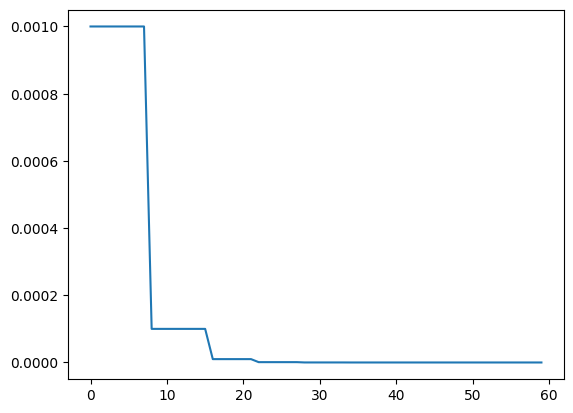

In [22]:
plt.plot(lr_list)
plt.show()

C:\Users\voron\AppData\Local\Temp\ipykernel_16724\2730620038.py:3: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend("train_loss", "val_loss")


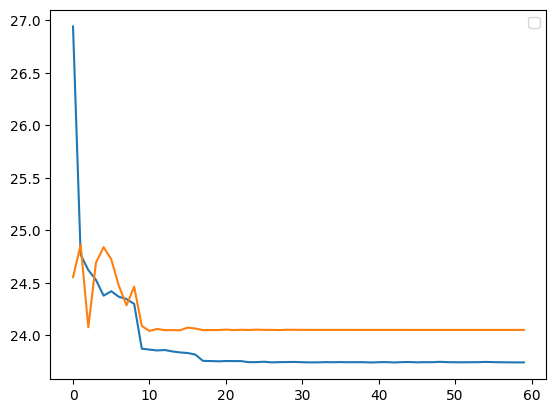

In [23]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend("train_loss", "val_loss")
plt.show()

C:\Users\voron\AppData\Local\Temp\ipykernel_16724\1924809399.py:3: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend("train_acc", "val_acc")


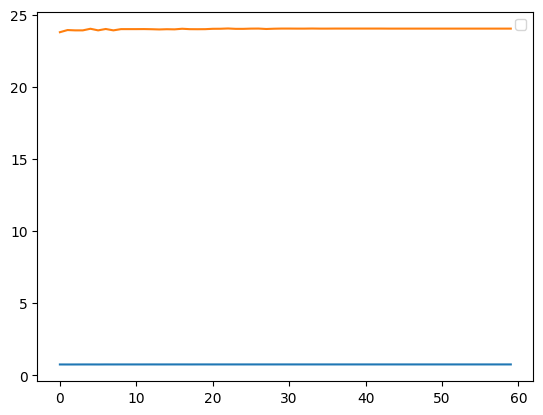

In [24]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend("train_acc", "val_acc")
plt.show()